In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kpmg-internship/new_customers.csv
/kaggle/input/kpmg-internship/customer_transactions.csv
/kaggle/input/kpmg-internship/customer_demographic.csv
/kaggle/input/kpmg-internship/customer_address.csv


In [2]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import OrdinalEncoder
#from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, recall_score, precision_score

In [3]:
def change_gender(gender):
    
    if gender[0] == 'F':
        gender = 'Female'
        
    if gender[0] == 'M':
        gender = 'Male'
     
    return gender

In [4]:
def wrangle_customer_demo(filepath):
    
    df = pd.read_csv(filepath).set_index('customer_id')
    
    df['gender'] = df['gender'].apply(change_gender)
    
    df['job_industry_category'].fillna('Other', inplace=True)
    

    #Drop rows with empty values
    df.drop(index = df[df['DOB'].isna()].index, inplace= True)
    
    
    df['age'] = 2018 - df['DOB'].str.slice(0,4).astype(int)
    
    df.drop(index = df[df['age'] == 175].index, inplace = True)
    
    # Create age group column
    df['age_group'] = (df['age'] // 10).astype(str)
    #df[df['age'] == 2018]['age'].replace()
    
    df.drop(index = df[df['deceased_indicator'] == 'Y'].index, inplace = True)
    
    #Drop columns with high modularity
    drop_cols = ['first_name', 'last_name', 'job_title', 'DOB', 'deceased_indicator', 'age']
    df.drop(columns = drop_cols, inplace = True)
    return df

In [5]:
cust_demo_df = wrangle_customer_demo('../input/kpmg-internship/customer_demographic.csv')
cust_demo_df.head()

,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,owns_car,tenure,age_group
customer_id,,,,,,,
1,Female,93,Health,Mass Customer,Yes,11.0,6
2,Male,81,Financial Services,Mass Customer,Yes,16.0,3
3,Male,61,Property,Mass Customer,Yes,15.0,6
4,Male,33,IT,Mass Customer,No,7.0,5
5,Female,56,Other,Affluent Customer,Yes,8.0,4


In [6]:
cust_transact_df = pd.read_csv('../input/kpmg-internship/customer_transactions.csv')
cust_transact_df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,5,78,787,01/10/2017,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,$709.48,42226.0
1,6,25,2339,08/03/2017,True,Approved,Giant Bicycles,Road,medium,medium,1538.99,$829.65,39031.0
2,15,12,247,11/06/2017,False,Approved,Giant Bicycles,Standard,medium,large,1765.30,$709.48,38193.0
3,18,33,1842,02/06/2017,False,Approved,Giant Bicycles,Standard,medium,small,1311.44,"$1,167.18",33888.0
4,20,25,3002,28/01/2017,True,Approved,Giant Bicycles,Road,medium,medium,1538.99,$829.65,37337.0


In [7]:
def get_prices_df(transactions_df):
    # Group transactions by customer
    group_transact_by_customer = transactions_df.groupby('customer_id')
    # Get number of transactions by each customer
    count_transact_by_customer = group_transact_by_customer['transaction_id'].count()
    # Get total amount spent by each customer
    total_spend_by_customer = group_transact_by_customer['list_price'].sum()
    
    # Change the data type of the standard cost column
    cust_transact_df['standard_cost'] = cust_transact_df['standard_cost'].str.replace('$', '')
    cust_transact_df['standard_cost'] = cust_transact_df['standard_cost'].str.replace(',', '')
    
    cust_transact_df['standard_cost'] = cust_transact_df['standard_cost'].astype(float)
    
    total_cost_by_customer = group_transact_by_customer['standard_cost'].sum()
    
    total_profit_by_customer = total_spend_by_customer - total_cost_by_customer
    
    mean_spend_by_customer = group_transact_by_customer['list_price'].mean()
    
    mean_cost_by_customer = group_transact_by_customer['standard_cost'].mean()
    
    mean_profit_by_customer = mean_spend_by_customer - mean_cost_by_customer
    
    final_prices_df = pd.DataFrame({'count_transact': count_transact_by_customer, 
                                'total_spend': total_spend_by_customer, 
                                'total_profit': total_profit_by_customer, 
                                'mean_spend': mean_spend_by_customer, 
                                'mean_profit': mean_profit_by_customer})
    
    tenp, ninetyp = final_prices_df['mean_spend'].quantile([0.01, 0.99])
    
    final_prices_df = final_prices_df[final_prices_df['mean_spend'].between(tenp, ninetyp)]
    
    return final_prices_df

In [8]:
final_prices_df = get_prices_df(cust_transact_df)
final_prices_df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # Remove the CWD from sys.path while we load stuff.


,count_transact,total_spend,total_profit,mean_spend,mean_profit
customer_id,,,,,
1,11,9084.45,3018.090000,825.859091,274.371818
2,3,4149.07,2226.260000,1383.023333,742.086667
3,8,9888.23,3362.810000,1236.028750,420.351250
4,2,1047.72,220.570000,523.860000,110.285000
5,6,5903.20,2394.940000,983.866667,399.156667
...,...,...,...,...,...
3497,3,3744.07,1648.320000,1248.023333,549.440000
3498,6,5177.06,3147.330000,862.843333,524.555000
3499,7,7673.48,4955.250000,1096.211429,707.892857


In [9]:
def wrangle_address(filepath):
    df = pd.read_csv(filepath)
    
    df.drop(columns = ['country', 'address', 'postcode'], inplace = True)
    
    df['state'] = df['state'].replace(to_replace = {'New South Wales' : 'NSW', 'Victoria': 'VIC'})
    
    return df

In [10]:
cust_address = wrangle_address('../input/kpmg-internship/customer_address.csv').set_index('customer_id')
cust_address

,state,property_valuation
customer_id,,
1,NSW,10
2,NSW,10
4,QLD,9
5,NSW,4
6,VIC,9
...,...,...
3999,VIC,3
4000,QLD,6
4001,NSW,10


In [11]:
df = pd.concat([cust_demo_df, cust_address, final_prices_df[['mean_spend']]], axis = 1, join = 'inner' )
df

,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,owns_car,tenure,age_group,state,property_valuation,mean_spend
customer_id,,,,,,,,,,
1,Female,93,Health,Mass Customer,Yes,11.0,6,NSW,10,825.859091
2,Male,81,Financial Services,Mass Customer,Yes,16.0,3,NSW,10,1383.023333
4,Male,33,IT,Mass Customer,No,7.0,5,QLD,9,523.860000
5,Female,56,Other,Affluent Customer,Yes,8.0,4,NSW,4,983.866667
6,Male,35,Retail,High Net Worth,Yes,13.0,5,VIC,9,1186.338000
...,...,...,...,...,...,...,...,...,...,...
3496,Male,99,Manufacturing,Mass Customer,Yes,19.0,3,NSW,9,1181.345000
3497,Female,73,Manufacturing,Affluent Customer,Yes,18.0,3,VIC,5,1248.023333
3498,Female,28,Manufacturing,Mass Customer,No,5.0,2,VIC,4,862.843333


In [12]:
df['mean_spend'].describe()

count    3343.000000
mean     1105.884408
std       257.140599
min       405.405000
25%       933.927857
50%      1103.790000
75%      1280.158500
max      1769.640000
Name: mean_spend, dtype: float64

For this phase of the project, we will take our high value customers to be customers who have a mean spend of 1279 and above. This is the value of the 75th percentile.

In [13]:
df['high_value'] = df['mean_spend'] > 1280
df.drop(columns = 'mean_spend', inplace = True)
df.head()

,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,owns_car,tenure,age_group,state,property_valuation,high_value
customer_id,,,,,,,,,,
1,Female,93,Health,Mass Customer,Yes,11.0,6,NSW,10,False
2,Male,81,Financial Services,Mass Customer,Yes,16.0,3,NSW,10,True
4,Male,33,IT,Mass Customer,No,7.0,5,QLD,9,False
5,Female,56,Other,Affluent Customer,Yes,8.0,4,NSW,4,False
6,Male,35,Retail,High Net Worth,Yes,13.0,5,VIC,9,False


# TRAIN A RANDOM FOREST CLASSIFIER

In [14]:
df['high_value'].value_counts(normalize = True)

False    0.749626
True     0.250374
Name: high_value, dtype: float64

In [15]:
baseline_acc_score = df['high_value'].value_counts(normalize = True).max()
baseline_acc_score

0.7496260843553695

## Split the data.  

### Vertical Split

In [16]:
target = 'high_value'
X = df.drop(columns = target)
y = df[target]
print(X.shape)

(3343, 9)


### Horizontal Split 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2)
print(X_train.shape)
print(y_train.shape)

(2674, 9)
(2674,)


## Resample my training data

In [18]:
oversampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)


In [19]:
print(y_train_over.shape)

(3996,)


### Create my pipeline

In [20]:
clf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=42)
)
clf

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [21]:
params = {
    'randomforestclassifier__n_estimators': range(50,151,25),
    'randomforestclassifier__max_depth':range(10,50,10)
         }

In [22]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv = 5,
    n_jobs = -1,
    verbose = 1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(50, 151, 25)},
             verbose=1)

### Fit the model to the training set

In [23]:
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(50, 151, 25)},
             verbose=1)

In [24]:
cv_results = pd.DataFrame(model.cv_results_).sort_values('rank_test_score')
cv_results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.392707,0.012104,0.036805,0.000882,20,50,"{'randomforestclassifier__max_depth': 20, 'ran...",0.88250,0.894869,0.938673,0.913642,0.937422,0.913421,0.022424,1
7,0.731726,0.016159,0.057643,0.001751,20,100,"{'randomforestclassifier__max_depth': 20, 'ran...",0.88500,0.884856,0.933667,0.917397,0.933667,0.910917,0.022036,2
17,0.691438,0.008154,0.057161,0.002432,40,100,"{'randomforestclassifier__max_depth': 40, 'ran...",0.87875,0.881101,0.924906,0.924906,0.934919,0.908916,0.023963,3
19,0.940143,0.101937,0.064915,0.011564,40,150,"{'randomforestclassifier__max_depth': 40, 'ran...",0.88250,0.872340,0.928661,0.921151,0.937422,0.908415,0.026025,4
12,0.697705,0.004792,0.056763,0.000927,30,100,"{'randomforestclassifier__max_depth': 30, 'ran...",0.87875,0.881101,0.924906,0.921151,0.934919,0.908166,0.023505,5
14,1.046176,0.012581,0.077204,0.000974,30,150,"{'randomforestclassifier__max_depth': 30, 'ran...",0.88250,0.872340,0.928661,0.919900,0.937422,0.908165,0.025907,6
8,0.854992,0.003413,0.066371,0.002810,20,125,"{'randomforestclassifier__max_depth': 20, 'ran...",0.88875,0.876095,0.934919,0.912390,0.928661,0.908163,0.022623,7
6,0.572637,0.024096,0.052091,0.007041,20,75,"{'randomforestclassifier__max_depth': 20, 'ran...",0.87875,0.883605,0.933667,0.911139,0.932416,0.907915,0.023304,8
9,0.995754,0.006738,0.074481,0.001827,20,150,"{'randomforestclassifier__max_depth': 20, 'ran...",0.88500,0.877347,0.932416,0.913642,0.928661,0.907413,0.022458,9
10,0.372774,0.007355,0.038157,0.003063,30,50,"{'randomforestclassifier__max_depth': 30, 'ran...",0.88125,0.882353,0.919900,0.923655,0.928661,0.907164,0.020897,10


In [25]:
tr_thresholds = []
tr_precision_scores = []
tr_recall_scores = []
for threshold in np.arange(0,1.1,0.1):
    tr_thresholds.append(threshold)
    y_pred_train = model.predict_proba(X_train)[:,1] >= threshold
    tr_precision_scores.append(precision_score(y_train, y_pred_train))
    tr_recall_scores.append(recall_score(y_train, y_pred_train))
    

train_scores_df = pd.DataFrame({'threshold': tr_thresholds, 
                          'precisions_score' : tr_precision_scores, 
                          'recall_score': tr_recall_scores}).sort_values('recall_score')
    
train_scores_df

,threshold,precisions_score,recall_score
10,1.0,1.000000,0.134615
9,0.9,1.000000,0.717456
8,0.8,1.000000,0.893491
7,0.7,1.000000,0.958580
6,0.6,1.000000,0.997041
0,0.0,0.252805,1.000000
1,0.1,0.342278,1.000000
2,0.2,0.707113,1.000000
3,0.3,0.969871,1.000000
4,0.4,0.998523,1.000000


In [26]:
thresholds = []
precision_scores = []
recall_scores = []
for threshold in np.arange(0,1.1,0.1):
    thresholds.append(threshold)
    y_pred_test = model.predict_proba(X_test)[:,1] >= threshold
    precision_scores.append(precision_score(y_test, y_pred_test))
    recall_scores.append(recall_score(y_test, y_pred_test))
    

test_scores_df = pd.DataFrame({'threshold': thresholds, 
                          'precisions_score' : precision_scores, 
                          'recall_score': recall_scores}).sort_values('recall_score')
    
test_scores_df

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,precisions_score,recall_score
8,0.8,0.000000,0.000000
9,0.9,0.000000,0.000000
10,1.0,0.000000,0.000000
7,0.7,0.142857,0.006211
6,0.6,0.200000,0.031056
5,0.5,0.263736,0.149068
4,0.4,0.265625,0.316770
3,0.3,0.246499,0.546584
2,0.2,0.250865,0.900621
1,0.1,0.242792,0.993789


The discussion to be having is this. Do we want high recall or high precision. We can see from our confusion matrix that our model is already exhibiting high precision - we do not have any false positives. However, since we are trying to gain customers, it would be better if we had a higher recall. We would like to catch as many high value customers as possible. This confusion matrix shows us that we need to reduce the number or false negatives.

I have decied to use a threshold of 0.3 as i believe this gives the best trade off


In [27]:
y_pred_test = model.predict_proba(X_test)[:,1] >= 0.3

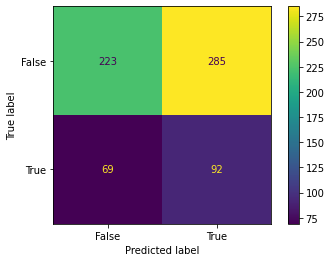

In [28]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)

View the Feature Importances

In [29]:
features = X_train.columns
importances = model.best_estimator_.named_steps['randomforestclassifier'].feature_importances_
importances

feat_imp = pd.DataFrame({'gini': importances}).set_index(features).sort_values('gini', ascending = False)
feat_imp

,gini
past_3_years_bike_related_purchases,0.262054
tenure,0.191489
property_valuation,0.147506
job_industry_category,0.128234
age_group,0.093252
wealth_segment,0.059932
state,0.053550
gender,0.040461
owns_car,0.023520


<AxesSubplot:>

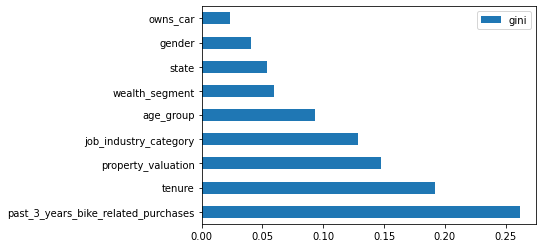

In [30]:
feat_imp.plot(kind = 'barh')

In [31]:
def wrangle_new_customer(filepath):
    
    df = pd.read_csv(filepath)
    
    df['gender'] = df['gender'].apply(change_gender)
    
    df['job_industry_category'].fillna('Other', inplace=True)
    

    #Drop rows with empty values
    df.drop(index = df[df['DOB'].isna()].index, inplace= True)
    
    
    df['age'] = 2018 - df['DOB'].str.slice(0,4).astype(int)
    
    #df.drop(index = df[df['age'] == 175].index, inplace = True)
    
    # Create age group column
    df['age_group'] = (df['age'] // 10).astype(str)
    #df[df['age'] == 2018]['age'].replace()
    
    df.drop(index = df[df['deceased_indicator'] == 'Y'].index, inplace = True)
    
    #Drop columns with high modularity
    drop_cols = ['first_name', 'last_name', 'job_title', 'DOB', 'deceased_indicator', 'age',
                 'country', 'postcode', 'Column1', 'Column2', 'Column3', 'Column4', 
                 'Column5', 'Column9', 'Rank', 'Value', 'address']
    df.drop(columns = drop_cols, inplace = True)
    
    cols = df.columns.tolist()
    cols.insert(6, 'age_group')
    cols = cols[:-1]
    
    df = df[cols]
    
    return df

In [32]:
new_cust_df = wrangle_new_customer('../input/kpmg-internship/new_customers.csv')
new_cust_df

,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,owns_car,tenure,age_group,state,property_valuation
0,Female,64,Manufacturing,Affluent Customer,Yes,5,3,QLD,1.0
1,Female,48,Financial Services,Affluent Customer,Yes,13,4,QLD,1.0
2,Female,14,Financial Services,Affluent Customer,Yes,19,6,QLD,1.0
3,Female,95,Other,Mass Customer,No,5,5,NSW,1.0
4,Female,66,Health,Affluent Customer,No,21,6,VIC,1.0
...,...,...,...,...,...,...,...,...,...
995,Female,14,Other,High Net Worth,No,13,2,NSW,12.0
996,Female,74,Manufacturing,High Net Worth,No,14,5,NSW,12.0
997,Female,77,Financial Services,Affluent Customer,Yes,10,1,VIC,12.0
998,Male,93,Argiculture,Mass Customer,Yes,9,3,NSW,12.0


In [33]:
prospects = model.predict_proba(new_cust_df)[:,1] >= 0.3
high_value_customers = new_cust_df[prospects]

In [34]:
high_value_customers['property_valuation'].value_counts(normalize=True)

9.0     0.171790
8.0     0.148282
7.0     0.135624
10.0    0.101266
4.0     0.074141
6.0     0.074141
5.0     0.066908
3.0     0.056058
12.0    0.050633
11.0    0.048825
2.0     0.047016
1.0     0.025316
Name: property_valuation, dtype: float64